
Entraînement fold 1
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - loss: 0.0386 - mae: 0.2189 - val_loss: 0.3092 - val_mae: 0.6319
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0053 - mae: 0.0803 - val_loss: 0.3083 - val_mae: 0.6444
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0042 - mae: 0.0689 - val_loss: 0.2655 - val_mae: 0.5836
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0035 - mae: 0.0663 - val_loss: 0.2483 - val_mae: 0.5578
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0031 - mae: 0.0601 - val_loss: 0.2416 - val_mae: 0.5452
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0023 - mae: 0.0537 - val_loss: 0.2414 - val_mae: 0.5477
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0026 - mae: 0.0566 - val_loss: 0.2513 - val_mae: 0.5623
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0023 - mae: 0.0533 - val_loss: 0.2689 - val_mae: 0.5861
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━

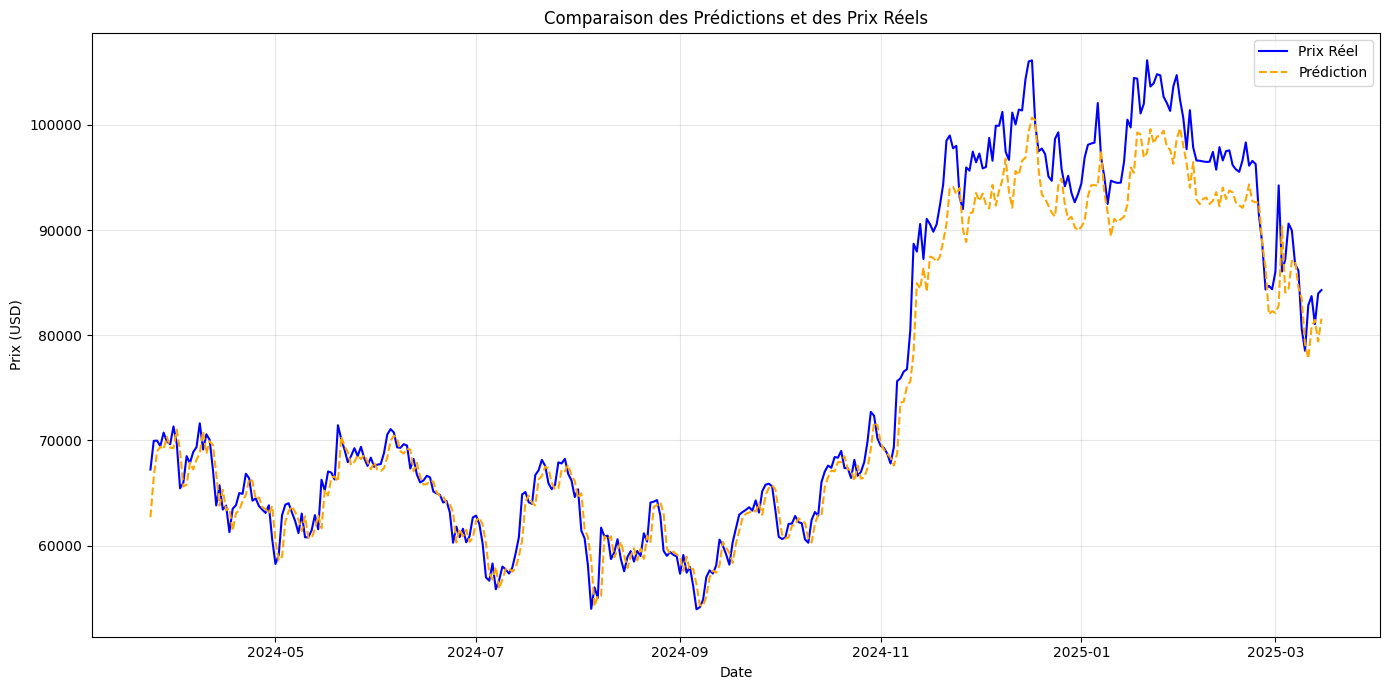


Modèle sauvegardé à : models/crypto_predictor.keras
Processeur sauvegardé à : models/crypto_processor.joblib


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import joblib
import os

# Configuration optimisée
SEQ_LENGTH = 60
TARGET_COL = 'Close'
BATCH_SIZE = 16
MODEL_SAVE_PATH = 'models/crypto_predictor.keras'
PROCESSOR_SAVE_PATH = 'models/crypto_processor.joblib'

class CryptoDataProcessor:
    def __init__(self, seq_length):
        self.scaler = RobustScaler()
        self.seq_length = seq_length
        self.feature_cols = None
        self.target_idx = None

    def process_features(self, data):
        """Feature engineering spécifique crypto"""
        df = data.copy()

        # Calcul des indicateurs techniques
        df['Volatility'] = (df['High'] - df['Low']) / df['Low'].rolling(24).mean()
        df['Momentum'] = df['Close'].pct_change(periods=12)
        df['EMA_20'] = df['Close'].ewm(span=20).mean()

        # Nettoyage final
        df = df.dropna()
        return df

    def prepare_data(self, data, is_train=True):
        """Préparation des données avec gestion de la temporalité"""
        processed = self.process_features(data)

        if is_train:
            self.scaler.fit(processed)
            self.feature_cols = [col for col in processed.columns if col != TARGET_COL]
            self.target_idx = processed.columns.get_loc(TARGET_COL)

        scaled = self.scaler.transform(processed)
        sequences, targets = [], []

        for i in range(len(scaled) - self.seq_length):
            sequences.append(scaled[i:i+self.seq_length])
            targets.append(scaled[i+self.seq_length, self.target_idx])

        return np.array(sequences), np.array(targets)

    def inverse_transform(self, scaled_targets):
        """Conversion inverse correcte des prédictions"""
        dummy = np.zeros((len(scaled_targets), len(self.feature_cols)+1))
        dummy[:, self.target_idx] = scaled_targets
        return self.scaler.inverse_transform(dummy)[:, self.target_idx]

def build_trading_model(input_shape):
    """Architecture simplifiée avec régularisation"""
    inputs = Input(shape=input_shape)

    # Augmentation temporelle
    x = GaussianNoise(0.01)(inputs)

    # Couches principales
    x = Conv1D(32, 3, padding='same', activation='relu')(x)
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.3)(x)

    # Sortie
    outputs = Dense(1)(x)

    return Model(inputs, outputs)

def exponential_correction(predictions, true_values, alpha=0.3):
    """Post-processing par lissage exponentiel"""
    corrected = [predictions[0]]
    for p, t in zip(predictions[1:], true_values[:-1]):
        corrected.append(alpha * p + (1 - alpha) * t)
    return np.array(corrected)

if __name__ == "__main__":
    # Création du répertoire pour les modèles
    os.makedirs('models', exist_ok=True)

    # Chargement des données
    data = pd.read_csv('bitcoin_full_dataset.csv', parse_dates=['Date'])
    data = data.set_index('Date')[['Close', 'High', 'Low', 'Volume']]

    # Initialisation du processeur
    processor = CryptoDataProcessor(SEQ_LENGTH)

    # Division temporelle stricte
    train_data = data.loc[:'2023-12-31']
    test_data = data.loc['2024-01-01':]

    # Préparation des données
    X_train, y_train = processor.prepare_data(train_data, is_train=True)
    X_test, y_test = processor.prepare_data(test_data, is_train=False)

    # Validation croisée temporelle
    tscv = TimeSeriesSplit(n_splits=3)
    best_weights = None
    best_val_mae = float('inf')

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
        print(f"\nEntraînement fold {fold+1}")

        model = build_trading_model(X_train.shape[1:])
        model.compile(
            optimizer=Adam(learning_rate=0.001, clipvalue=0.5),
            loss='huber',
            metrics=['mae']
        )

        history = model.fit(
            X_train[train_idx], y_train[train_idx],
            validation_data=(X_train[val_idx], y_train[val_idx]),
            epochs=100,
            batch_size=BATCH_SIZE,
            verbose=1,
            callbacks=[
                EarlyStopping(patience=20, restore_best_weights=True),
                ModelCheckpoint(f'best_fold{fold}.keras')
            ]
        )

        # Sélection des meilleurs poids
        val_mae = min(history.history['val_mae'])
        if val_mae < best_val_mae:
            best_weights = model.get_weights()
            best_val_mae = val_mae

    # Initialisation du modèle final
    final_model = build_trading_model(X_train.shape[1:])
    final_model.set_weights(best_weights)

    # Évaluation finale
    raw_pred = final_model.predict(X_test).flatten()
    smooth_pred = exponential_correction(raw_pred, y_test)

    # Conversion en dollars
    y_test_dollar = processor.inverse_transform(y_test)
    pred_dollar = processor.inverse_transform(smooth_pred)

    # Calcul des métriques
    mae = mean_absolute_error(y_test_dollar, pred_dollar)
    volatility = np.std(y_test_dollar)

    print("\nPerformance finale:")
    print(f"- MAE: {mae:.2f}")
    print(f"- Volatilité: {volatility:.2f}")
    print(f"- Ratio MAE/Volatilité: {(mae/volatility)*100:.1f}%")

    # Visualisation des résultats
    processed_test = processor.process_features(test_data)
    test_dates = processed_test.index[SEQ_LENGTH:]

    plt.figure(figsize=(14, 7))
    plt.plot(test_dates, y_test_dollar, label='Prix Réel', color='blue')
    plt.plot(test_dates, pred_dollar, label='Prédiction', color='orange', linestyle='--')
    plt.title('Comparaison des Prédictions et des Prix Réels')
    plt.xlabel('Date')
    plt.ylabel('Prix (USD)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('prediction_comparison.png')
    plt.show()

    # Sauvegarde du modèle et du processeur pour Streamlit
    final_model.save(MODEL_SAVE_PATH)
    joblib.dump(processor, PROCESSOR_SAVE_PATH)
    print(f"\nModèle sauvegardé à : {MODEL_SAVE_PATH}")
    print(f"Processeur sauvegardé à : {PROCESSOR_SAVE_PATH}")